# Project: Convolutional Neural Networks: Recognizing Street View Housing Number Digits

**Project: Convolutional Neural Networks: Recognizing Street View Housing Number Digits**
Marks: 30
Hello, and thank you for joining us here at the project on classifying data using convolutional neural
networks. Regarding this undertaking, we will keep using the Street View Housing Numbers (SVHN)
picture collection as our primary resource.
Context: **
———————
Recognizing things in their natural settings is one of the most fascinating challenges in the field of deep
learning. The capacity to analyze visual information using machine learning algorithms may be highly
valuable, as shown by a variety of applications.
The SVHN dataset includes approximately 600,000 digits that have been identified and were clipped
from street-level photographs. It is one of the image recognition datasets that is used the most often. It
has been put to use in the neural networks that Google has developed in order to enhance the quality of
maps by automatically trancribing address numbers from individual pixel clusters. The combination of
the transcribed number and the known street address makes it easier to locate the building that the
number represents.
Objective: **
————————
Develop a CNN model that is capable of recognizing the digits that are shown in the photos.
Dataset:
To reduce the amount of time spent computing, we will only utilize a portion of the whole original data.
The dataset is supplied to you in the form of a.h5 file. All of the fundamental preprocessing procedures
have been completed.

## 1. Imports

In [1]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random state

np.random.seed(20)

## 2. Loading and preprocessing

In [3]:
# Load the data

train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


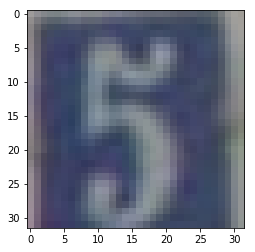

Label:  [5]


In [7]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [8]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [9]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [11]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [12]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [13]:
y_val.shape

(10989, 10)

## 3. CNN model

In order to get more robust results out of our model, we are going to augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down (**IMPORTANT NOTE:** It is best that we do not shift them horizontally, since there are also distracting digits in the images), shifting their channels and shearing them.

In [14]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In order to determine a good learning rate for the optimizer of our model (here, we use the AMSGrad variant of the Adam optimizer), we set a callback in an auxillary model which will gradually increase the learning rate of the optimizer.

In [15]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(lr=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
# Fit model in order to determine best learning rate

history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule])

Epoch 1/30
487/487 [==============================] - 48s 99ms/step - loss: 2.3097 - accuracy: 0.1623 - val_loss: 2.1997 - val_accuracy: 0.1952
Epoch 2/30
487/487 [==============================] - 42s 86ms/step - loss: 2.0999 - accuracy: 0.2363 - val_loss: 1.6548 - val_accuracy: 0.4767
Epoch 3/30
487/487 [==============================] - 42s 86ms/step - loss: 1.4596 - accuracy: 0.5030 - val_loss: 0.8105 - val_accuracy: 0.7608
Epoch 4/30
487/487 [==============================] - 42s 86ms/step - loss: 0.9751 - accuracy: 0.6840 - val_loss: 0.5200 - val_accuracy: 0.8439
Epoch 5/30
487/487 [==============================] - 42s 86ms/step - loss: 0.7480 - accuracy: 0.7638 - val_loss: 0.4612 - val_accuracy: 0.8578
Epoch 6/30
487/487 [==============================] - 43s 87ms/step - loss: 0.6080 - accuracy: 0.8126 - val_loss: 0.3406 - val_accuracy: 0.8967
Epoch 7/30
487/487 [==============================] - 42s 86ms/step - loss: 0.5210 - accuracy: 0.8401 - val_loss: 0.3231 - val_accuracy:

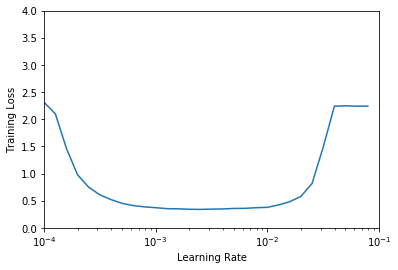

In [17]:
# Plot Learning Rate vs. Loss

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 4])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

We can see that the loss follows a very specific trajectory: a rapid drop followed by a relatively flat line which shoots back up after a certain point. Thus, it is better to choose a learning rate in the region where the loss is stable; a reasonable choice would be **lr = 0.01** (or 1e-3).

In [18]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

In [20]:
# Fit model in order to make predictions

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 55s 112ms/step - loss: 2.0616 - accuracy: 0.2553 - val_loss: 1.2829 - val_accuracy: 0.5667
Epoch 2/70
487/487 [==============================] - 42s 86ms/step - loss: 1.3558 - accuracy: 0.4867 - val_loss: 0.8218 - val_accuracy: 0.7591
Epoch 3/70
487/487 [==============================] - 42s 85ms/step - loss: 0.8860 - accuracy: 0.6971 - val_loss: 0.4350 - val_accuracy: 0.8703
Epoch 4/70
487/487 [==============================] - 41s 85ms/step - loss: 0.5242 - accuracy: 0.8482 - val_loss: 0.2929 - val_accuracy: 0.9173
Epoch 5/70
487/487 [==============================] - 42s 86ms/step - loss: 0.4185 - accuracy: 0.8805 - val_loss: 0.2750 - val_accuracy: 0.9227
Epoch 6/70
487/487 [==============================] - 42s 87ms/step - loss: 0.3743 - accuracy: 0.8933 - val_loss: 0.2622 - val_accuracy: 0.9280
Epoch 7/70
487/487 [==============================] - 42s 86ms/step - loss: 0.3401 - accuracy: 0.9040 - val_loss: 0.2343 - val_accuracy

In [21]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

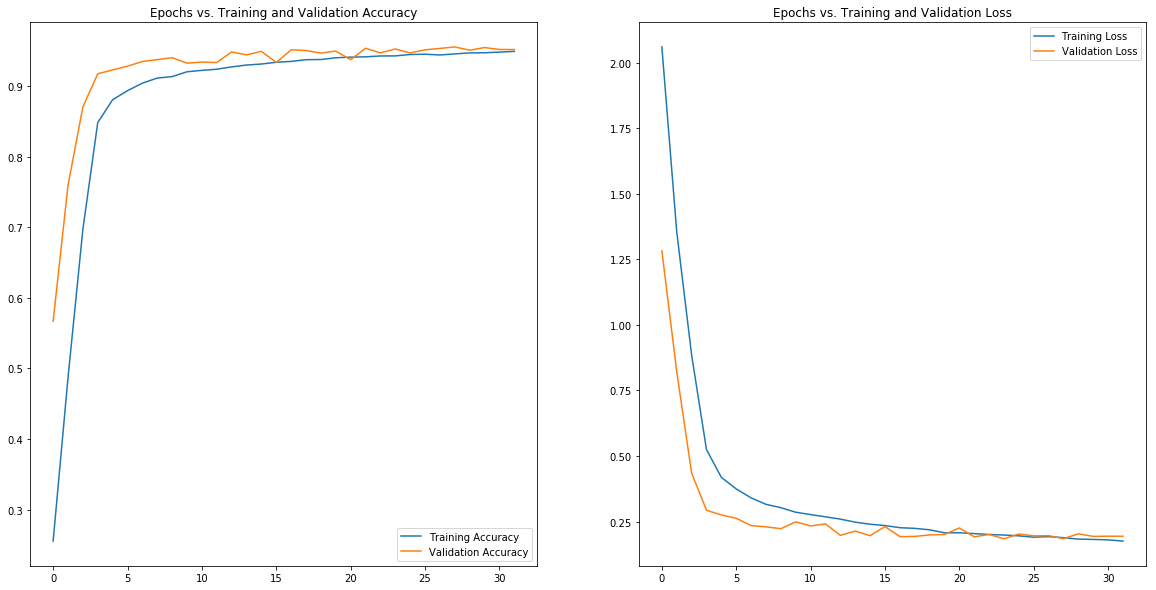

In [22]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

After seeing how the algorithm converged, we can now evaluate the model's performance on the test data.

In [23]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9553 
Test loss is: 0.1801


Not bad at all! This result implies that our error ranges from ~4% to ~4.4% and we should have in mind that the errors reported by state-of-the-art models and methods range from 4.9% to 1.02% ([reference](https://benchmarks.ai/svhn)). Of course, there is room for quite a bit of tuning in order to improve performance such as:
- Change the way the images are transformed in the augmentation process.
- Change the architecture of our model by adding extra blocks, changing the kernel sizes, making it deeper, etc.
- Train multiple CNNs and make ensemble predictions.
- Use some of the extra data which can be found along with the original dataset. 

## 4. Visualizations and insights

In this section, we can present some nice and useful visualizations which make us understand better how our Convolutional Neural Network actually works. It is my belief that the two following visualizations are the most helpful:

- The **Confusion Matrix** of the model on the training data, so as to get a sense of how it performs on each class label and how the misclassifications are distributed.
- The **Feature Maps** for a random input image, so as to get a sense of how our model learns the features in each convolutional layer.

In [24]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

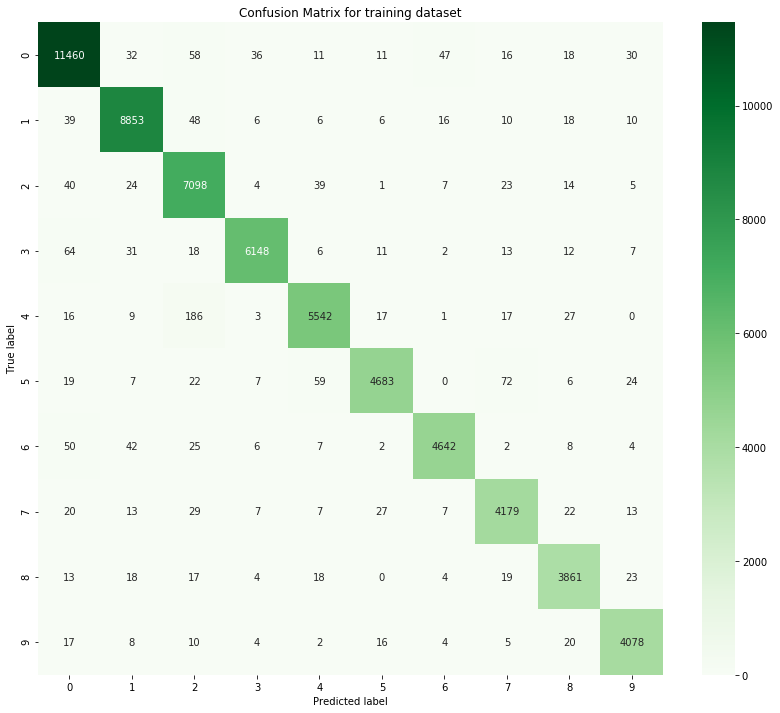

In [25]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

As we can see, the training data consists mostly of 0s, 1s and 2s (in a descending order), while labels '5' up to '9' are underepresented. Furthermore, the confusion matrix can show us the particular problematic cases of our model.

In [26]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [27]:
# Get convolutional layers

layers = [model.get_layer('conv2d_1'), 
          model.get_layer('conv2d_2'),
          model.get_layer('conv2d_3'),
          model.get_layer('conv2d_4'),
          model.get_layer('conv2d_5'),
          model.get_layer('conv2d_6')]

In [28]:
# Define a model which gives the outputs of the layers

layer_outputs = [layer.output for layer in layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [29]:
# Create a list with the names of the layers

layer_names = []
for layer in layers:
    layer_names.append(layer.name)

In [30]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

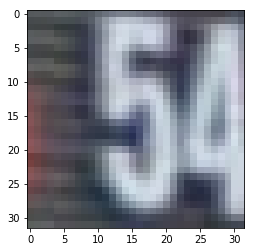

In [31]:
img = X_train[42500]
plt.imshow(img)
plt.show()

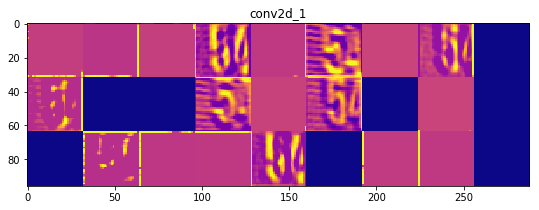

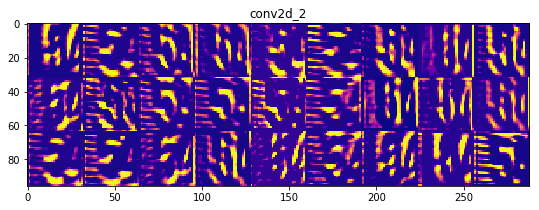

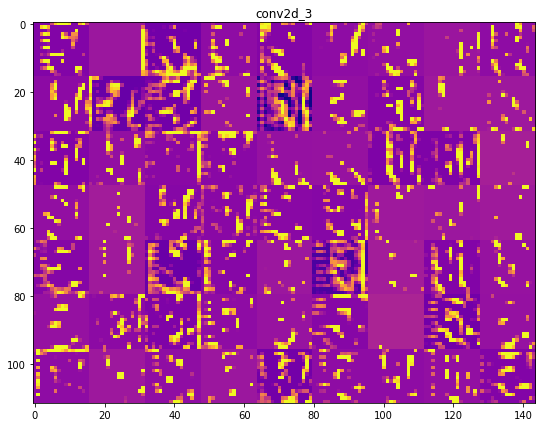

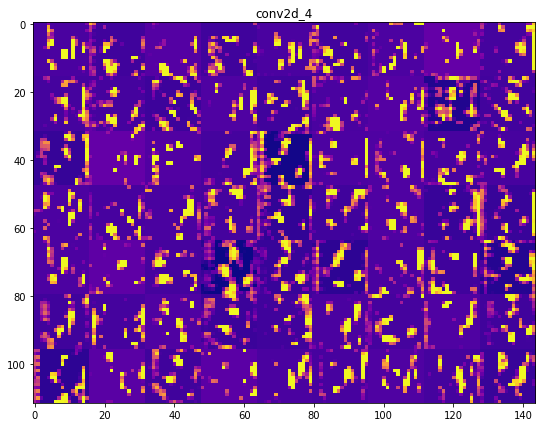

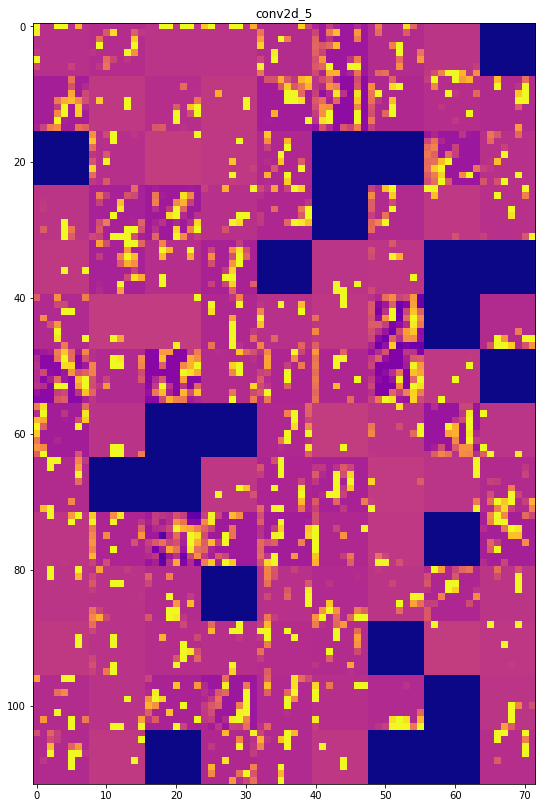

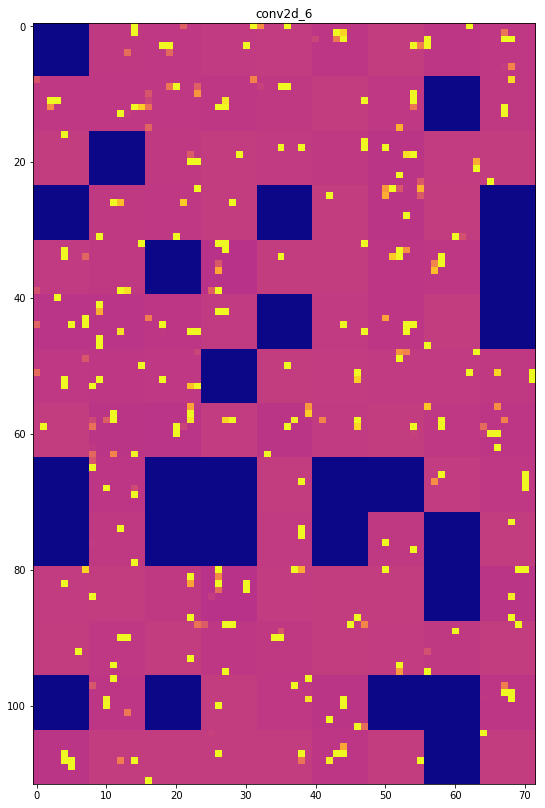

In [32]:
plot_convolutional_filters(img)

In the above, we can see the main idea behind Convolutional Neural Networks, i.e. that as we go deeper into the layers, higher-level features are learned by our models. At first, we can easily understand what is going on but gradually, we find it difficult to keep up with the model's learning process.

## 5. Conclusion

In this kernel, we have trained a Convolutional Neural Network to recognize the digits in the Street View House Numbers dataset (Format 2). In particular, we have performed some minimal preprocessing of the data, we have augmented the data in various ways, we have created an auxillary model in order to find which learning rate we should choose for our optimizer and finally, we have trained the final CNN and evaluated it on the test images data. Furthermore, we have provided two useful visualizations (confusion matrix and feature maps) so as get a sense of how our model actually works and not view it as just a black-box process. Finally, it should be noted that there is quite a bit of room for tuning and different architectures so as to improve the accuracy of the model; nonetheless, our results are pretty good given the simplicity of our approach.

